In [1]:
import sys
sys.path.append('..\\src')
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

---
### Fit signal demo

pk_pars_opt:  {'vp': 0.011017305583538405, 'ps': 0.00010761506843007133, 've': 0.9795975822527067, 'vi': 0.0, 'vb': 0.02040241774729334} s0_opt:  25918.02471694431


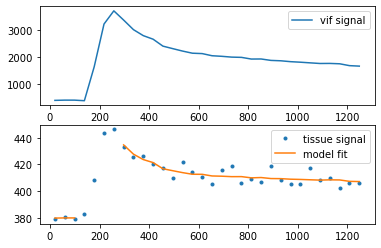

In [15]:
from dce import fit, pk_models, aifs, relax, signal_models, water_ex_models

# DCE data (subject 4)
t = np.array([19.810000,59.430000,99.050000,138.670000,178.290000,217.910000,257.530000,297.150000,336.770000,376.390000,416.010000,455.630000,495.250000,534.870000,574.490000,614.110000,653.730000,693.350000,732.970000,772.590000,812.210000,851.830000,891.450000,931.070000,970.690000,1010.310000,1049.930000,1089.550000,1129.170000,1168.790000,1208.410000,1248.030000])
s_vif = np.array([411.400000,420.200000,419.600000,399.000000,1650.400000,3229.200000,3716.200000,3375.600000,3022.000000,2801.200000,2669.800000,2413.800000,2321.400000,2231.400000,2152.800000,2138.200000,2059.200000,2037.600000,2008.200000,1998.800000,1936.800000,1939.400000,1887.000000,1872.800000,1840.200000,1820.400000,1796.200000,1773.000000,1775.600000,1762.000000,1693.400000,1675.800000])
s_tissue = np.array([378.774277,380.712810,378.789773,382.467975,407.950413,443.482955,446.239153,433.392045,425.428202,426.274793,420.676653,417.144112,410.072831,422.042355,414.013430,410.885847,405.251033,415.864669,418.615186,406.327479,408.692149,406.797004,418.646694,408.176136,404.993285,405.098140,417.022211,408.189050,409.819731,401.988636,405.866219,406.299587])
r0_tissue = relax.relaxation(r_1 = 1./1.3651, r_2s = 0.)
r0_vif = relax.relaxation(r_1 = 1./1.7206, r_2s = 0.)
k_vif, k_tissue = 0.9946, 1.2037
hct = 0.46
tr, fa_rad, te = 3.4e-3, 15.*(np.pi/180.), 1.7e-3

# processing options
baseline_idx = [0,1,2]
rlxy = relax.relaxivity(r_1 = 5.0, r_2s = 7.1)
c_to_r_model = relax.c_to_r_linear(rlxy)
signal_model = signal_models.spgr(tr, fa_rad, te)
water_ex_model = water_ex_models.ntexl()
fit_opts = {'pk_pars_0': {'vp': 0.2, 'ps': 1e-4},
            't_mask': np.array(np.concatenate([np.ones(3), np.zeros(4), np.ones(25)]),dtype=bool) }

# estimate VIF conc
enh_vif = fit.s_to_e(s_vif, baseline_idx)
c_p_vif = fit.e_to_c(enh_vif, k_vif, r0_vif, c_to_r_model, signal_model) / (1 - hct)
dt_interp_request = (t[1]-t[0])/1.
aif = aifs.patient_specific(t, c_p_vif)

# fit the tissue signal
pk_model = pk_models.patlak(t, dt_interp_request, aif, hct) 
pk_pars_opt, s0_opt, s_fit = fit.s_to_pkp(s_tissue, k_tissue, r0_tissue, r0_vif, pk_model, c_to_r_model, water_ex_model, signal_model, fit_opts=fit_opts)
print('pk_pars_opt: ', pk_pars_opt, 's0_opt: ', s0_opt)

fig, ax = plt.subplots(2,1)
ax[0].plot(t, s_vif, label='vif signal')
ax[0].legend();
ax[1].plot(t, s_tissue, '.', label='tissue signal')
ax[1].plot(t, s_fit, '-', label='model fit')
ax[1].legend();

# expected values for FXL fit: vp = 0.00801, ps = 2.01e-4
# expected values for SXL fit: vp = 0.01126, ps = 1.13e-4